In [1]:
## 라이브러리 임포트, 시드고정
import os
import json 
import random
import numpy as np
import cv2 # ⭐️ OpenCV 임포트

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
import copy

# ⭐️ Albumentations 임포트
import albumentations as A 
from albumentations.pytorch import ToTensorV2 

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# ⭐️ Deterministic 연산을 위한 환경 변수 설정 (에러 해결) ⭐️
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {device}")

# ★ 경로 설정 (사용자 환경에 맞게 수정) ★
# 🚨 주의: 이 경로는 'train/happy' 등의 하위 폴더를 포함해야 합니다.
IMG_ROOT = "/workspace/merge_data/data/img" 

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
# ⭐️ 4진 분류 타겟 감정 정의
TARGET_EMOTIONS = ["anger", "happy", "panic", "sadness"] 

# ----------------------------------------------------------------------
## 데이터 유효성 검증 (cv2 대신 PIL을 사용하므로 기존 코드 유지)
# ----------------------------------------------------------------------
def validate_image_data(root_dir):
    print(f"🔍 데이터 검증 시작: {root_dir}")
    total_files = 0
    corrupt_files = 0
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')
    
    for root, dirs, files in os.walk(root_dir):
        image_files = [f for f in files if f.lower().endswith(valid_ext)]
        if len(image_files) > 0:
            print(f"  📁 Folder: {os.path.basename(root)} | Images: {len(image_files)}")
            
            # ⭐️ PIL 대신 cv2를 사용해 로딩 테스트 가능 (다만 cv2는 corrupt file 체크가 까다로움)
            # 여기서는 원본 코드대로 PIL.Image를 사용하여 verify()를 진행합니다.
            from PIL import Image
            for img_file in tqdm(image_files, desc=f"Checking {os.path.basename(root)}", leave=False):
                img_path = os.path.join(root, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, SyntaxError) as e:
                    print(f"    ❌ Corrupt file found: {img_path}")
                    corrupt_files += 1
                total_files += 1

    print("-" * 40)
    print(f"✅ 검증 완료")
    print(f"   - 총 이미지 수: {total_files}")
    print(f"   - 손상된 파일 수: {corrupt_files}")
    if corrupt_files > 0:
        print("⚠️ 경고: 손상된 파일이 존재합니다. 해당 파일을 제거하거나 확인해주세요.")
    else:
        print("🎉 모든 파일이 정상입니다.")

# 검증 실행
if os.path.exists(IMG_ROOT):
    validate_image_data(IMG_ROOT)
else:
    print(f"❌ 경로 오류: {IMG_ROOT} 가 존재하지 않습니다.")

# ----------------------------------------------------------------------
## ⭐️ Dataset 클래스 수정 (cv2 로딩 및 4진 분류 레이블)
# ----------------------------------------------------------------------
class EmotionDataset(Dataset):
    def __init__(self, img_root, split="train", transform=None):
        self.img_root = os.path.join(img_root, split)
        self.transform = transform
        
        # ⭐️ 4진 분류 레이블 맵핑
        self.emotions = TARGET_EMOTIONS # ["anger", "happy", "panic", "sadness"]
        self.label_map = {emo: i for i, emo in enumerate(self.emotions)}
        self.samples = []
        
        valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')

        print(f"\n[{split.upper()} Dataset Loading...]")
        
        for emo in self.emotions:
            emo_dir = os.path.join(self.img_root, emo)
            
            if not os.path.isdir(emo_dir):
                print(f"  [WARN] Folder not found: {emo_dir}")
                continue
                
            label = self.label_map[emo]
            
            for filename in os.listdir(emo_dir):
                if filename.lower().endswith(valid_ext):
                    img_path = os.path.join(emo_dir, filename)
                    self.samples.append((img_path, label))

        random.shuffle(self.samples)
        print(f"  >> Total {split} samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            # ⭐️ cv2를 사용하여 이미지 로드 (BGR 포맷으로 로드됨)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error: Failed to load image with cv2: {img_path}. Skipping to index 0.")
                return self.__getitem__(0)
                
            # BGR을 RGB로 변환 (Albumentations는 RGB 입력을 기대함)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        except Exception as e:
            print(f"Error loading/converting image {img_path}: {e}. Skipping to index 0.")
            return self.__getitem__(0)

        if self.transform is not None:
            # ⭐️ Albumentations는 dictionary 형태로 이미지 전달
            augmented = self.transform(image=image) 
            image = augmented['image']

        label = torch.tensor(label, dtype=torch.long)
        return image, label

# ----------------------------------------------------------------------
## ⭐️ Albumentations Transforms 및 DataLoader 정의
# ----------------------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(224, 224), # ResNet 기본 입력 크기
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(), # NumPy 배열 -> PyTorch Tensor
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

# 데이터셋 생성
train_dataset = EmotionDataset(IMG_ROOT, split="train", transform=train_transform)
val_dataset   = EmotionDataset(IMG_ROOT, split="val",   transform=val_transform)

# 데이터로더 생성 (pin_memory=True는 데이터 전송 가속화)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)
val_loader   = DataLoader(
    val_dataset,    
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

print("\n✅ DataLoaders and Albumentations are ready.")


# ----------------------------------------------------------------------
## CBAM 모듈 및 ResNetCBAM 모델 정의 (⭐️ num_classes=4로 변경)
# ----------------------------------------------------------------------
print("🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...")

# (ChannelAttention, SpatialAttention, CBAM 클래스 정의는 동일하게 유지됩니다.)
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__(); self.avg_pool = nn.AdaptiveAvgPool2d(1); self.max_pool = nn.AdaptiveMaxPool2d(1); self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False), nn.ReLU(), nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)); self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x)); max_out = self.fc(self.max_pool(x)); out = avg_out + max_out; return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__(); self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False); self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True); max_out, _ = torch.max(x, dim=1, keepdim=True); x_out = torch.cat([avg_out, max_out], dim=1); x_out = self.conv1(x_out); return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__(); self.ca = ChannelAttention(in_planes, ratio); self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        out = x * self.ca(x); out = out * self.sa(out); return out

# ⭐️ ResNetCBAM 모델 정의: num_classes=4로 변경
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=4): # ⭐️ 4진 분류
        super(ResNetCBAM, self).__init__()
        
        # 1. 사전학습된 ResNet18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # ResNet의 구성 요소 복사
        self.conv1 = resnet.conv1; self.bn1 = resnet.bn1; self.relu = resnet.relu; self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1; self.layer2 = resnet.layer2; self.layer3 = resnet.layer3; self.layer4 = resnet.layer4
        
        # ⭐️ Stage 2, 3에 CBAM 모듈 초기화
        self.cbam2 = CBAM(128) 
        self.cbam3 = CBAM(256) 
        
        self.avgpool = resnet.avgpool
        
        # 최종 분류기를 4클래스로 교체
        num_features = resnet.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        
        x = self.layer1(x)
        
        x = self.layer2(x); x = self.cbam2(x) # ⭐️ Stage 2 CBAM
        
        x = self.layer3(x); x = self.cbam3(x) # ⭐️ Stage 3 CBAM
        
        x = self.layer4(x)
        
        x = self.avgpool(x); x = torch.flatten(x, 1); x = self.fc(x)
        return x

# 모델, 손실함수, 최적화함수 초기화
model = ResNetCBAM(num_classes=len(TARGET_EMOTIONS)).to(device) # ⭐️ 4클래스로 초기화
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready for 4-class classification!")

# ----------------------------------------------------------------------
## 학습 함수 정의 (기존 코드 유지)
# ----------------------------------------------------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict()); best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}"); print("-" * 30)

        # ---- Train ----
        model.train(); running_loss = 0.0; running_corrects = 0; total = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device); labels = labels.to(device); optimizer.zero_grad()
            outputs = model(inputs); loss = criterion(outputs, labels); _, preds = torch.max(outputs, 1)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * inputs.size(0); running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
        
        if device.type == 'cuda': torch.cuda.empty_cache()
        epoch_loss = running_loss / total; epoch_acc = running_corrects.double() / total
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # ---- Validation ----
        model.eval(); val_loss = 0.0; val_corrects = 0; val_total = 0
        with torch.inference_mode():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device); labels = labels.to(device)
                outputs = model(inputs); loss = criterion(outputs, labels); _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0); val_corrects += torch.sum(preds == labels.data); val_total += labels.size(0)

        if device.type == 'cuda': torch.cuda.empty_cache()
        val_loss /= val_total; val_acc = val_corrects.double() / val_total
        print(f"Val    Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Best Model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "Res_CBAM_v4_4class.pth") # ⭐️ 파일명 변경
            print(f"⭐ Best model saved! (Acc: {best_val_acc:.4f})")

    print(f"\nTraining Complete. Best Val Acc: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# ----------------------------------------------------------------------
## 학습 실행 및 성능 평가 (⭐️ 4진 분류에 맞게 수정)
# ----------------------------------------------------------------------

# 학습 시작
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Metrics 계산 (멀티클래스 지원을 위해 pos_label 제거, average='weighted' 사용)
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec  = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1   = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
cm   = confusion_matrix(all_labels, all_preds)

print("\n=== Val Metrics (4-class: anger, happy, panic, sadness) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision (Weighted): {prec:.4f}")
print(f"Recall (Weighted)   : {rec:.4f}")
print(f"F1-score (Weighted) : {f1:.4f}")
print("\nConfusion Matrix (rows: true, cols: pred)")
print(cm)

print("\nClassification report:")
# ⭐️ target_names에 4가지 감정을 사용
print(classification_report(all_labels, all_preds, target_names=TARGET_EMOTIONS, zero_division=0))

✅ Device set to: cuda
🔍 데이터 검증 시작: /workspace/merge_data/data/img
  📁 Folder: sadness | Images: 287


  📁 Folder: panic | Images: 292


  📁 Folder: happy | Images: 299


  📁 Folder: anger | Images: 288


  📁 Folder: sadness | Images: 281


  📁 Folder: panic | Images: 280


  📁 Folder: anger | Images: 291


  📁 Folder: happy | Images: 299


  📁 Folder: sadness | Images: 1471


  📁 Folder: panic | Images: 1453


  📁 Folder: happy | Images: 1493


  📁 Folder: anger | Images: 1424


----------------------------------------
✅ 검증 완료
   - 총 이미지 수: 8158
   - 손상된 파일 수: 0
🎉 모든 파일이 정상입니다.

[TRAIN Dataset Loading...]
  >> Total train samples: 5841

[VAL Dataset Loading...]
  >> Total val samples: 1151

✅ DataLoaders and Albumentations are ready.
🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...
✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready for 4-class classification!

Epoch 1/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   4%|▍         | 8/183 [00:05<01:13,  2.38it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   7%|▋         | 13/183 [00:07<01:15,  2.24it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   9%|▉         | 17/183 [00:09<01:10,  2.35it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  16%|█▋        | 30/183 [00:16<01:08,  2.22it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  19%|█▉        | 35/18

Train Loss: 0.8091 Acc: 0.6650


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:15,  2.06it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  25%|██▌       | 9/36 [00:06<00:17,  1.51it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  28%|██▊       | 10/36 [00:06<00:16,  1.62it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  39%|███▉      | 14/36 [00:08<00:12,  1.78it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for s

Val    Loss: 0.6424 Acc: 0.7654
⭐ Best model saved! (Acc: 0.7654)

Epoch 2/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   1%|          | 1/183 [00:02<07:39,  2.52s/it]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   4%|▍         | 8/183 [00:04<01:21,  2.16it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   7%|▋         | 12/183 [00:07<01:23,  2.04it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   9%|▊         | 16/183 [00:09<01:13,  2.26it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  10%|▉         | 18/183 [00:10<01:39,  1.65it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  13%|█▎ 

Train Loss: 0.3984 Acc: 0.8541


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:14,  2.28it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  17%|█▋        | 6/36 [00:04<00:19,  1.53it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  28%|██▊       | 10/36 [00:06<00:15,  1.70it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
V

Val    Loss: 0.6849 Acc: 0.7619

Epoch 3/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   1%|          | 1/183 [00:02<06:37,  2.19s/it]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   2%|▏         | 4/183 [00:02<01:26,  2.06it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   4%|▍         | 8/183 [00:05<01:11,  2.44it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   8%|▊         | 14/183 [00:08<01:27,  1.93it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  13%|█▎        | 23/183 [00:12<01:05,  2.46it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  19%|█▊        | 34/183 [00:17<01:14,  2.00it/s]Inva

Train Loss: 0.2450 Acc: 0.9166


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:16,  1.98it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:04<00:10,  2.70it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  25%|██▌       | 9/36 [00:06<00:17,  1.56it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  28%|██▊       | 10/36 [00:06<00:16,  1.53it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for se

Val    Loss: 0.6645 Acc: 0.7802
⭐ Best model saved! (Acc: 0.7802)

Epoch 4/10
------------------------------


Training:   5%|▍         | 9/183 [00:05<01:19,  2.19it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  15%|█▌        | 28/183 [00:15<01:14,  2.07it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  23%|██▎       | 42/183 [00:22<01:09,  2.03it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  25%|██▌       | 46/183 [00:24<01:07,  2.02it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  27%|██▋       | 50/183 [00:26<01:06,  2.01it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  28%|██▊       | 52/183 [00:26<00:58,  2.24it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training

Train Loss: 0.1522 Acc: 0.9509


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:14,  2.16it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:04<00:12,  2.32it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  25%|██▌       | 9/36 [00:05<00:16,  1.61it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  36%|███▌      | 13/36 [00:07<00:11,  2.01it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for se

Val    Loss: 0.7223 Acc: 0.7724

Epoch 5/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   7%|▋         | 13/183 [00:08<01:45,  1.62it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   9%|▊         | 16/183 [00:09<01:08,  2.42it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  20%|██        | 37/183 [00:22<01:16,  1.91it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  23%|██▎       | 43/183 [00:25<01:10,  1.98it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  27%|██▋       | 50/183 [00:28<00:53,  2.47it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  29%|██▉       | 53/183 [00:30<00:58,  2.23it/s]I

Train Loss: 0.1189 Acc: 0.9615


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:13,  2.30it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:05<00:11,  2.35it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  28%|██▊       | 10/36 [00:06<00:14,  1.75it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  39%|███▉      | 14/36 [00:08<00

Val    Loss: 1.0904 Acc: 0.7116

Epoch 6/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   4%|▍         | 7/183 [00:04<01:26,  2.03it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   7%|▋         | 12/183 [00:06<01:05,  2.63it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   8%|▊         | 14/183 [00:08<01:31,  1.85it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  14%|█▎        | 25/183 [00:13<01:08,  2.30it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  16%|█▌        | 29/183 [00:15<01:05,  2.37it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  18%|█▊        | 33/183 [00:17<00:59,  2.50it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Tr

Train Loss: 0.0754 Acc: 0.9765


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:17,  1.82it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:05<00:13,  2.06it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  31%|███       | 11/36 [00:06<00:11,  2.17it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  33%|███▎      | 12/36 [00:07<00:12,  1.94it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for s

Val    Loss: 0.8215 Acc: 0.7732

Epoch 7/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   2%|▏         | 3/183 [00:02<02:14,  1.34it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   6%|▌         | 11/183 [00:06<01:15,  2.27it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   8%|▊         | 15/183 [00:08<01:06,  2.54it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  11%|█         | 20/183 [00:10<00:53,  3.05it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  13%|█▎        | 24/183 [00:11<00:48,  3.30it/s]Invalid SOS param

Train Loss: 0.0588 Acc: 0.9812


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:03<00:19,  1.65it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:05<00:13,  2.14it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  33%|███▎      | 12/36 [00:07<00:09,  2.41it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  39%|███▉      | 14/36 [00:09<00:11,  1.84it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for s

Val    Loss: 0.8683 Acc: 0.7776

Epoch 8/10
------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   2%|▏         | 4/183 [00:02<01:21,  2.18it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   7%|▋         | 13/183 [00:07<01:12,  2.34it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   9%|▊         | 16/183 [00:07<00:52,  3.15it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  11%|█         | 20/183 [00:09<00:52,  3.10it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  24%|██▍       | 44/183 [00:20<00:50,  2.74it/s]Invalid SOS param

Train Loss: 0.0445 Acc: 0.9877


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:02<00:15,  2.05it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  17%|█▋        | 6/36 [00:04<00:17,  1.76it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  25%|██▌       | 9/36 [00:05<00:13,  2.03it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  31%|███       | 11/36 [00:06<00:11,  2.19it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  36%|███▌      | 

Val    Loss: 1.0389 Acc: 0.7637

Epoch 9/10
------------------------------


Training:   1%|          | 2/183 [00:02<02:56,  1.02it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  11%|█         | 20/183 [00:10<01:04,  2.53it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  13%|█▎        | 24/183 [00:12<01:02,  2.55it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  15%|█▌        | 28/183 [00:14<01:09,  2.25it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  16%|█▌        | 29/183 [00:15<01:20,  1.92it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  21%|██        | 38/183 [00:18<00:56,  2.57it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid 

Train Loss: 0.0514 Acc: 0.9820


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:   8%|▊         | 3/36 [00:02<00:19,  1.73it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  17%|█▋        | 6/36 [00:03<00:14,  2.00it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  31%|███       | 11/36 [00:05<00:09,  2.68it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  39%|███▉      | 14/36 [00:07<00:10,  2.18it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for s

Val    Loss: 0.9415 Acc: 0.7628

Epoch 10/10
------------------------------


Training:   2%|▏         | 3/183 [00:02<01:48,  1.66it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:   3%|▎         | 6/183 [00:04<01:52,  1.58it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  11%|█▏        | 21/183 [00:11<01:06,  2.44it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  14%|█▎        | 25/183 [00:12<00:58,  2.70it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  16%|█▌        | 29/183 [00:14<00:54,  2.83it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Training:  18%|█▊        | 33/183 [00:16<00:51,  2.89it/s]Invalid SOS parameters for sequential JPEG
Invalid S

Train Loss: 0.0402 Acc: 0.9873


Validation:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  11%|█         | 4/36 [00:03<00:21,  1.52it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  17%|█▋        | 6/36 [00:05<00:23,  1.29it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  22%|██▏       | 8/36 [00:06<00:16,  1.71it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  28%|██▊       | 10/36 [00:08<00:19,  1.35it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Validation:  39%|███▉      | 

Val    Loss: 0.9720 Acc: 0.7750

Training Complete. Best Val Acc: 0.7802

📊 최종 성능 평가 중...


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  11%|█         | 4/36 [00:02<00:14,  2.15it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  14%|█▍        | 5/36 [00:03<00:20,  1.50it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  25%|██▌       | 9/36 [00:05<00:15,  1.74it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  28%|██▊       | 10/36 [00:06<00:16,  1.60it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  39%|███▉      | 14/36 [00:08<00:12,  1.78it/s]Invalid SOS p


=== Val Metrics (4-class: anger, happy, panic, sadness) ===
Accuracy : 0.7802
Precision (Weighted): 0.7795
Recall (Weighted)   : 0.7802
F1-score (Weighted) : 0.7793

Confusion Matrix (rows: true, cols: pred)
[[194  12  50  35]
 [  6 274  11   8]
 [ 37  13 216  14]
 [ 35   8  24 214]]

Classification report:
              precision    recall  f1-score   support

       anger       0.71      0.67      0.69       291
       happy       0.89      0.92      0.90       299
       panic       0.72      0.77      0.74       280
     sadness       0.79      0.76      0.78       281

    accuracy                           0.78      1151
   macro avg       0.78      0.78      0.78      1151
weighted avg       0.78      0.78      0.78      1151




📊 최종 성능 평가 중...


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  11%|█         | 4/36 [00:02<00:16,  1.95it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  14%|█▍        | 5/36 [00:03<00:21,  1.45it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  17%|█▋        | 6/36 [00:04<00:21,  1.43it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  25%|██▌       | 9/36 [00:06<00:15,  1.76it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Evaluating:  36%|███▌      | 13/36 [00:07<00:10,  2.13it/s]Invalid SOS parameter

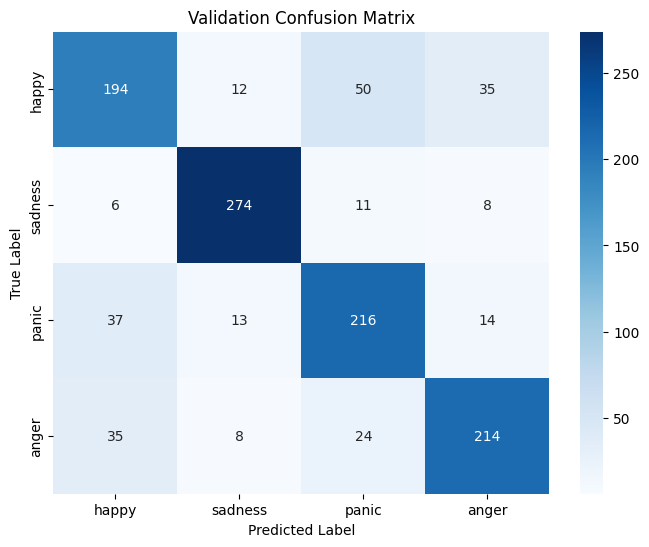

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
# 이 네 가지 라이브러리가 필요합니다.

def plot_confusion_matrix(all_labels, all_preds, target_emotions, title="Confusion Matrix"):
    """
    컨퓨전 매트릭스를 계산하고 히트맵으로 시각화합니다.
    
    Args:
        all_labels (np.array): 실제 레이블 (정답)
        all_preds (np.array): 모델의 예측 레이블
        target_emotions (list): 레이블 이름 리스트 (예: ['anger', 'happy', ...])
        title (str): 그래프 제목
    """
    
    # 1. 컨퓨전 매트릭스 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 2. 시각화 설정
    plt.figure(figsize=(8, 6))
    
    # 히트맵 생성 (fmt='d'는 정수형 포맷을 의미)
    sns.heatmap(
        cm, 
        annot=True,          # 셀 안에 값 표시
        fmt='d',             # 정수형 포맷
        cmap='Blues',        # 색상 맵 설정
        xticklabels=target_emotions, # X축 레이블 (예측)
        yticklabels=target_emotions  # Y축 레이블 (실제)
    )
    
    # 3. 레이블 및 제목 설정
    plt.title(title)
    plt.ylabel('True Label') # 실제 레이블 (정답)
    plt.xlabel('Predicted Label') # 예측 레이블
    plt.show()



TARGET_EMOTIONS = ["happy","sadness","panic","anger"]

# 📊 최종 성능 평가 수행 부분
trained_model = model # 학습된 모델을 사용하거나 불러온 모델을 사용
print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

if len(val_loader.dataset) > 0:
    with torch.inference_mode():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1) # 예측값 (클래스 인덱스)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # ⭐️ 시각화 함수 호출!
    plot_confusion_matrix(all_labels, all_preds, TARGET_EMOTIONS, "Validation Confusion Matrix")
    
    # ... (classification_report 출력 로직) ...
else:
    print("⚠️ 경고: 유효성 검증 데이터셋에 로드된 샘플이 없어 평가를 건너뜁니다.")